## House Price Prediction - Assignment
  
  ### To provide the solution we need to first understand and exploration data, Clean the data , Prepare the data and then build the model and evaluate the model


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

from scipy import stats
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Reading the dataset
house = pd.read_csv("train.csv", na_values="NAN")

In [3]:
# Let's take a look at the first few rows
house.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
!pip install sweetviz

In [5]:
#Auto EDA
import sweetviz as sv
sweet_report = sv.analyze(house)
sweet_report.show_html('sweet_report.html')

                                             |                                             | [  0%]   00:00 ->…

Report sweet_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [6]:
print(house.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

<Axes: xlabel='SalePrice', ylabel='Density'>

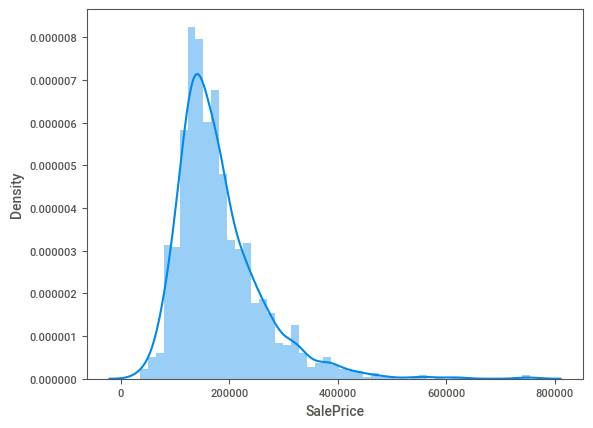

In [7]:
sns.distplot(house['SalePrice'])

In [8]:
print("Skewness: %f" % house['SalePrice'].skew())
print("Kurtosis: %f" % house['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


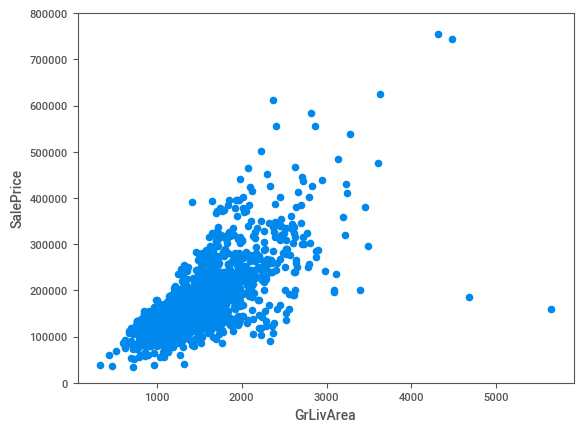

In [9]:
var = 'GrLivArea'
data = pd.concat([house['SalePrice'], house[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

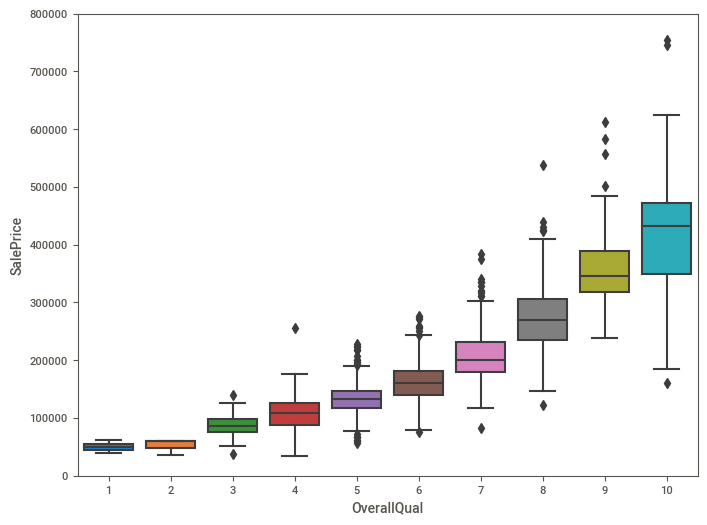

In [10]:
#box plot overallqual/saleprice
var = 'OverallQual'
data = pd.concat([house['SalePrice'], house[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

## variance in price increases with overall quality

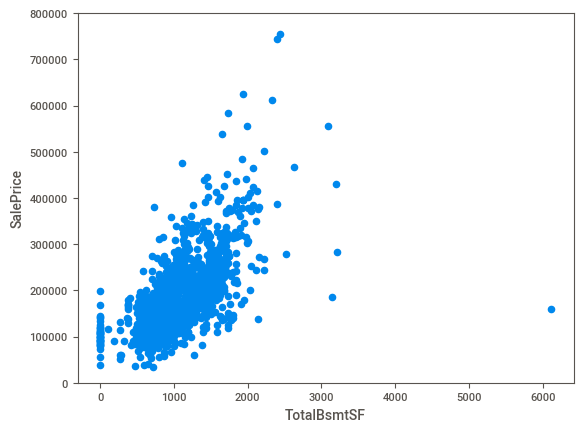

In [11]:
var = 'TotalBsmtSF'
data = pd.concat([house['SalePrice'], house[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

<Axes: >

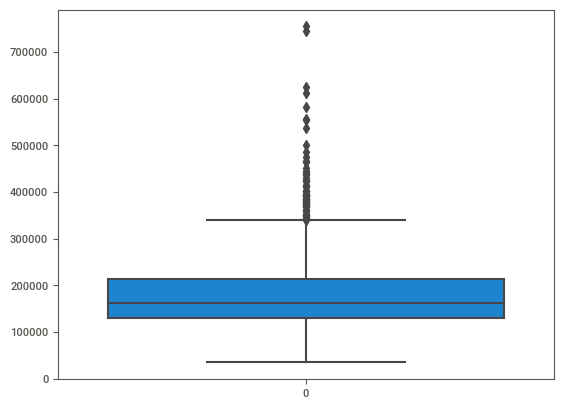

In [12]:
sns.boxplot(data['SalePrice'])

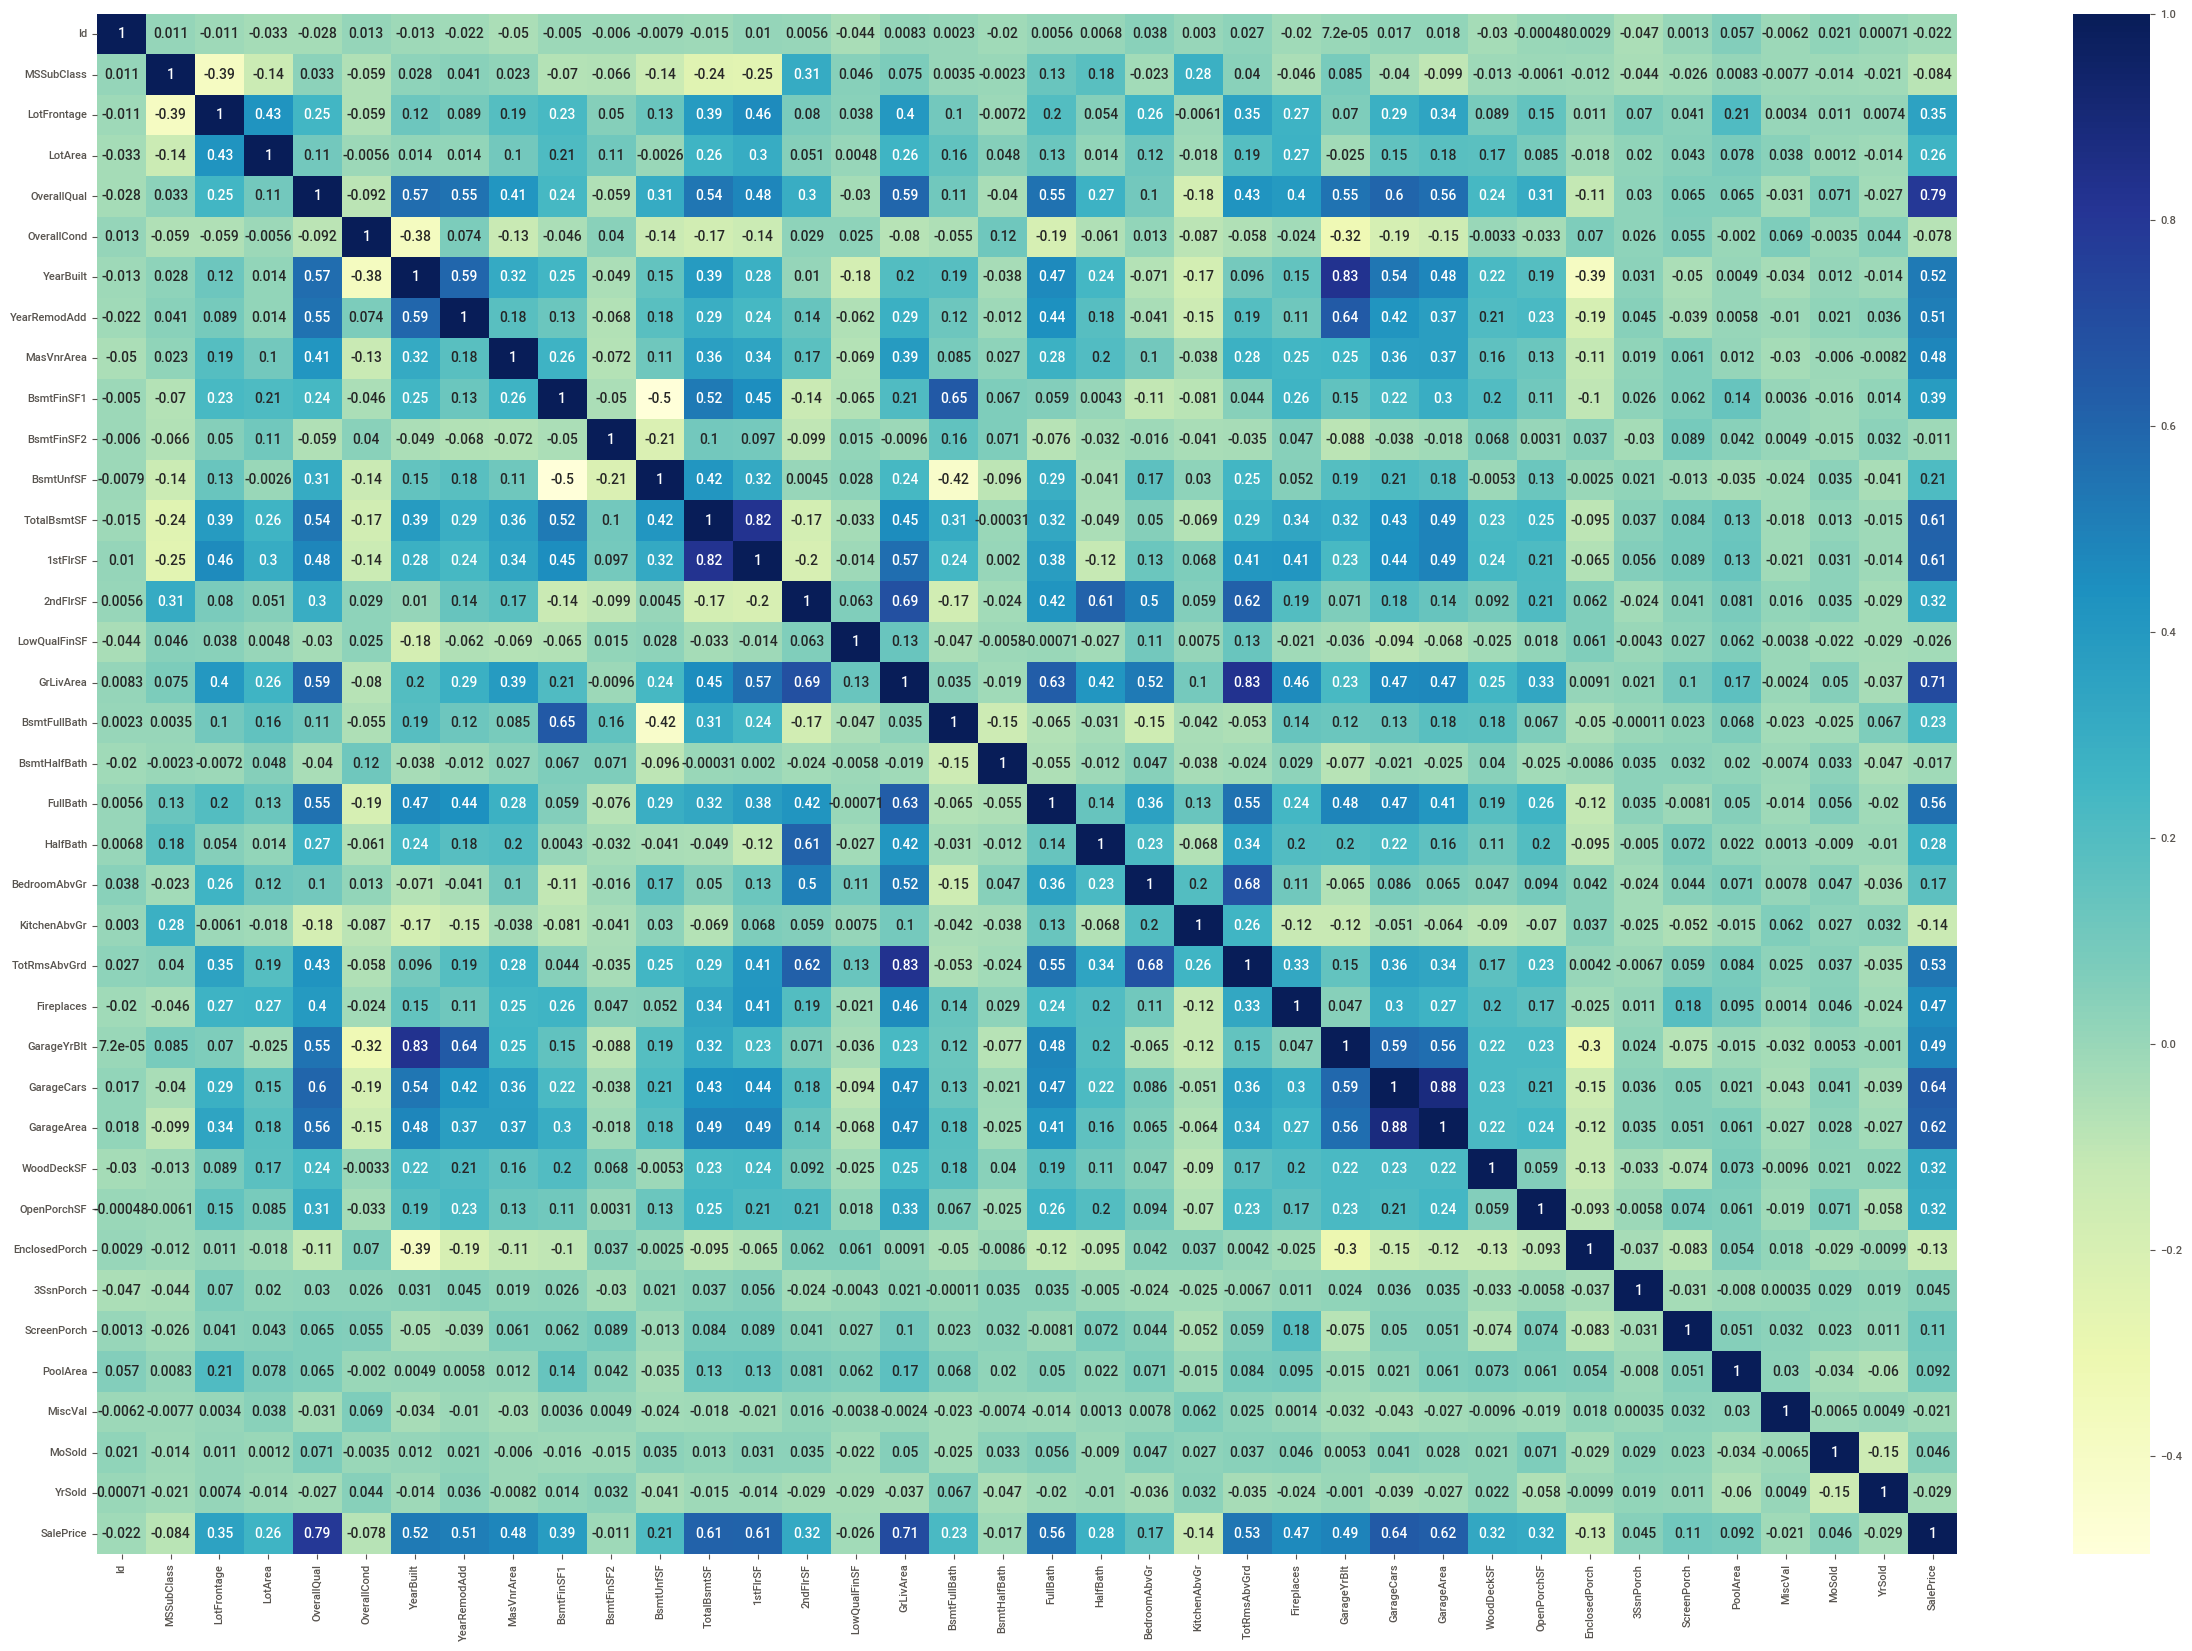

In [13]:
plt.figure(figsize = (30, 20))
corrmat = house.corr()
sns.heatmap(corrmat, annot = True, cmap="YlGnBu")
plt.show()

Inference:
From the above plots and heat map, we can see the 'SalePrice' has good linear relation with the following features:

'SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt'

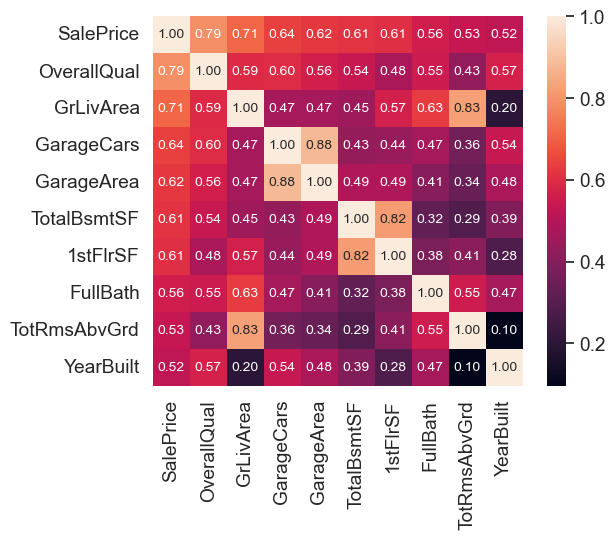

In [14]:
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(house[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

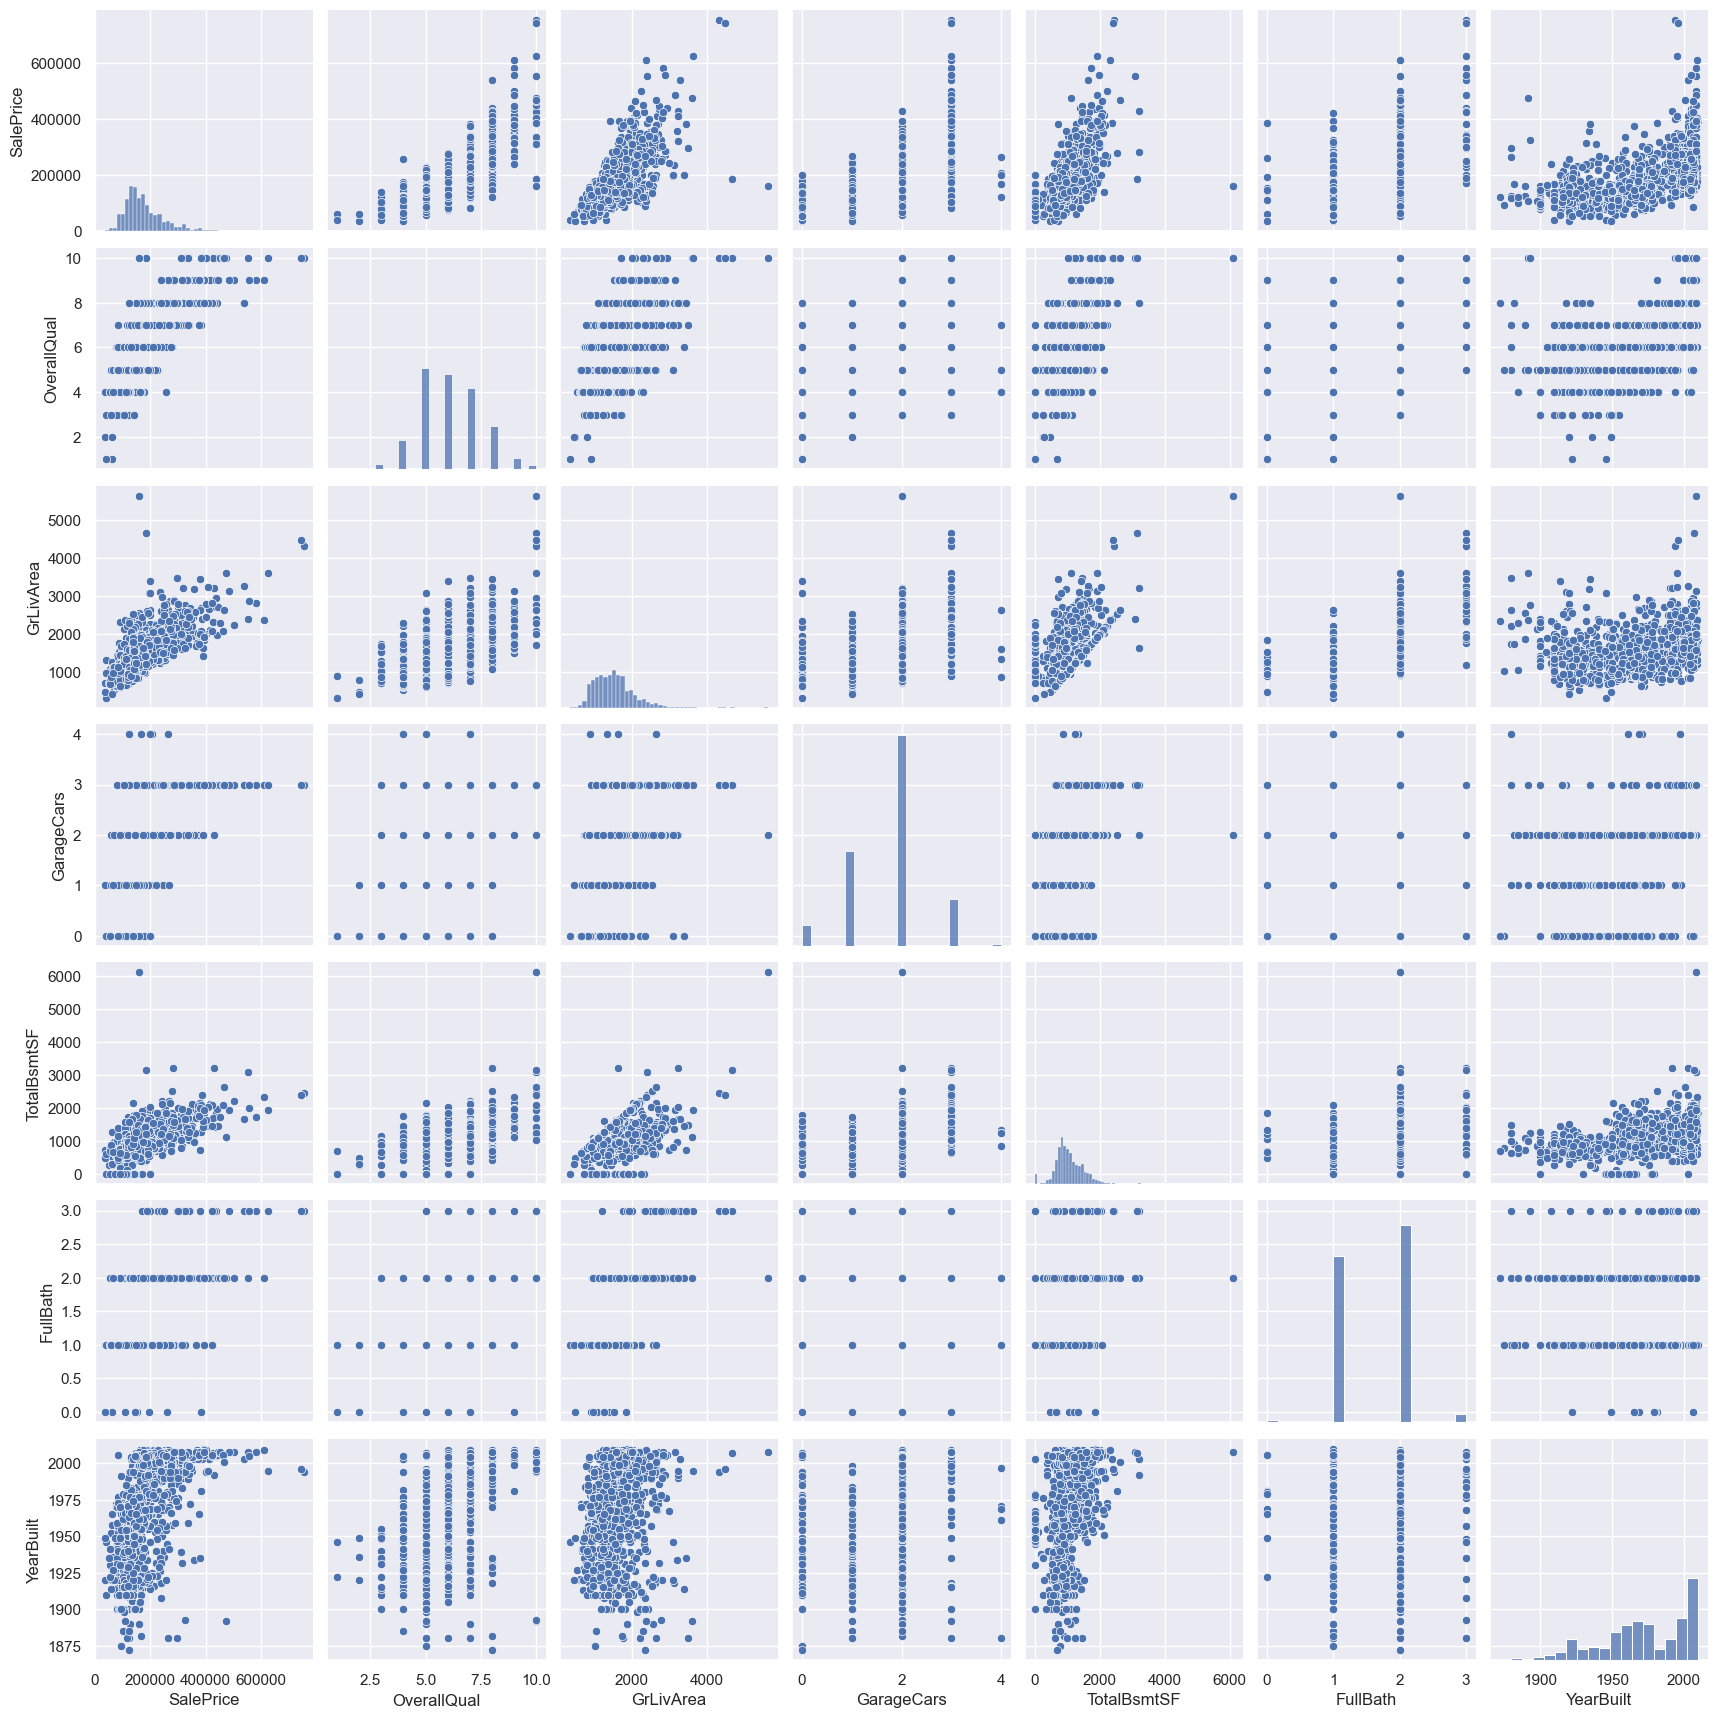

In [15]:
#scatterplot
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(house[cols], size = 2.5)
plt.show();

In [16]:
#missing data
total = house.isnull().sum().sort_values(ascending=False)
percent = (house.isnull().sum()/house.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
GarageCond,81,0.055479
GarageType,81,0.055479
GarageFinish,81,0.055479


## Imputing missing values


In [17]:
#you can find these features on the description data file provided

null_has_meaning = ["Alley", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "FireplaceQu", "GarageType", "GarageFinish", "GarageQual", "GarageCond", "PoolQC", "Fence", "MiscFeature"]

In [18]:
## As NaN Values are treated as null values we are changing it to None
for i in null_has_meaning:
    house[i].fillna("None", inplace=True)
    house[i].fillna("None", inplace=True)

In [19]:
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          1460 non-null   object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

## Imputing "Real" NaN Values

These are the real NaN values that we have to deal with accordingly because they were not recorded.

In [20]:
#from sklearn.preprocessing import Imputer
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(missing_values = np.nan, strategy="median")

In [21]:
#missing data
total = house.isnull().sum().sort_values(ascending=False)
percent = (house.isnull().sum()/house.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(6)

,Total,Percent
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
MasVnrType,8,0.005479
MasVnrArea,8,0.005479
Electrical,1,0.000685
KitchenQual,0,0.000000


In [22]:
#Dropping LotFrontage as its having high percentage value and it has too many Null values and numeric value
house.drop("LotFrontage", axis=1, inplace=True)

In [23]:
#Rechecking the missing data
#missing data
total = house.isnull().sum().sort_values(ascending=False)
percent = (house.isnull().sum()/house.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head()

,Total,Percent
GarageYrBlt,81,0.055479
MasVnrType,8,0.005479
MasVnrArea,8,0.005479
Electrical,1,0.000685
KitchenQual,0,0.000000


In [24]:
#GarageYrBlt, MasVnrArea, and MasVnrType all have a fairly decent amount of missing values. MasVnrType is categorical so we can replace the missing values with "None",
#as we did before. We can fill the others with median.

house["GarageYrBlt"].fillna(house["GarageYrBlt"].median(), inplace=True)
house["MasVnrArea"].fillna(house["MasVnrArea"].median(), inplace=True)
house["MasVnrType"].fillna("None", inplace=True)

In [25]:
# checking for missing data
#missing data
total = house.isnull().sum().sort_values(ascending=False)
percent = (house.isnull().sum()/house.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head()

,Total,Percent
Electrical,1,0.000685
MSSubClass,0,0.000000
GarageYrBlt,0,0.000000
GarageType,0,0.000000
FireplaceQu,0,0.000000


In [26]:
# Now only Electical is having null  
house.dropna(inplace=True)

In [27]:
#missing data
total = house.isnull().sum().sort_values(ascending=False)
percent = (house.isnull().sum()/house.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head()

,Total,Percent
Id,0,0.0
MSSubClass,0,0.0
GarageYrBlt,0,0.0
GarageType,0,0.0
FireplaceQu,0,0.0


In [28]:
print(house.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1459 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1459 non-null   object 
 3   LotArea        1459 non-null   int64  
 4   Street         1459 non-null   object 
 5   Alley          1459 non-null   object 
 6   LotShape       1459 non-null   object 
 7   LandContour    1459 non-null   object 
 8   Utilities      1459 non-null   object 
 9   LotConfig      1459 non-null   object 
 10  LandSlope      1459 non-null   object 
 11  Neighborhood   1459 non-null   object 
 12  Condition1     1459 non-null   object 
 13  Condition2     1459 non-null   object 
 14  BldgType       1459 non-null   object 
 15  HouseStyle     1459 non-null   object 
 16  OverallQual    1459 non-null   int64  
 17  OverallCond    1459 non-null   int64  
 18  YearBuil

In [29]:
#After handling the missing data 
#Auto EDA
import sweetviz as sv
sweet_report = sv.analyze(house,pairwise_analysis="off")
sweet_report.show_html('sweet_report.html')

                                             |                                             | [  0%]   00:00 ->…

Report sweet_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [30]:
# Now we will determine the data type of all features remaining
#if numeric values or categorical values
types_train = house.dtypes #type of each feature in data: int, float, object
num_train = types_train[(types_train == 'int64') | (types_train == float)] #numerical values are either type int or float
cat_train = types_train[types_train == object] #categorical values are type object


In [31]:
#printing differnt data types in the house dataset
pd.DataFrame(types_train).reset_index().set_index(0).reset_index()[0].value_counts()

object     43
int64      35
float64     2
Name: 0, dtype: int64

In [32]:
#we should convert num_train to a list to make it easier to work with ptinting numertical values
numerical_values_train = list(num_train.index)
print(numerical_values_train)

['Id', 'MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']


In [33]:
#getting categorical values and printing categorcal values
categorical_values_train = list(cat_train.index)
print(categorical_values_train)

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


# Data Preparation

<Axes: xlabel='SalePrice', ylabel='Density'>

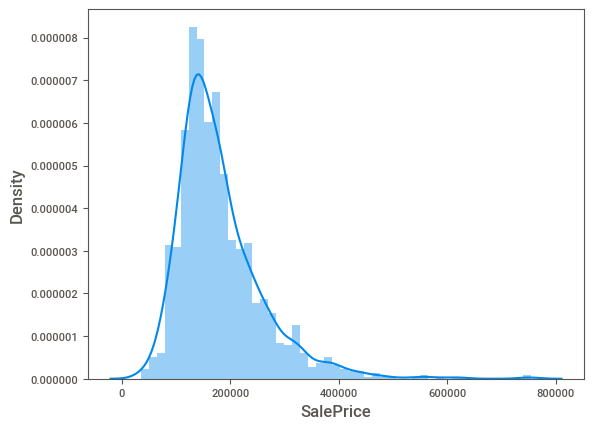

In [34]:
sns.distplot(house["SalePrice"])

<Axes: xlabel='SalePrice', ylabel='Density'>

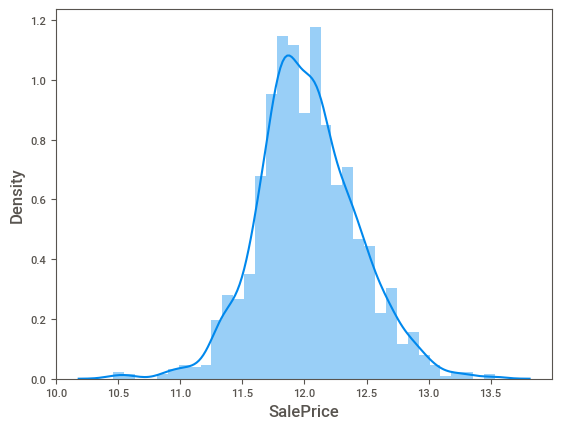

In [35]:
# converting to log scale 

sns.distplot(np.log(house["SalePrice"]))


# It appears that the target, SalePrice, is very skewed and a transformation like a logarithm would make it more normally distributed. Machine Learning models tend to work much better with normally distributed targets, rather than greatly skewed targets.
# By transforming the prices, we can boost model performance.

In [36]:
house["TransformedPrice"] = np.log(house["SalePrice"])

In [37]:
print(categorical_values_train)

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


In [38]:
#this code below will identify the categorical columns and assign a uinque numerical value to different categories like 1,2,3 etc
for i in categorical_values_train:
    feature_set = set(house[i])
    for j in feature_set:
        feature_list = list(feature_set)
        house.loc[house[i] == j, i] = feature_list.index(j)

In [39]:
house.head(5)

,Id,MSSubClass,MSZoning,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,TransformedPrice
0,1,60,1,8450,0,1,0,3,0,0,...,1,4,2,0,2,2008,1,5,208500,12.247694
1,2,20,1,9600,0,1,0,3,0,1,...,1,4,2,0,5,2007,1,5,181500,12.109011
2,3,60,1,11250,0,1,1,3,0,0,...,1,4,2,0,9,2008,1,5,223500,12.317167
3,4,70,1,9550,0,1,1,3,0,2,...,1,4,2,0,2,2006,1,1,140000,11.849398
4,5,60,1,14260,0,1,1,3,0,1,...,1,4,2,0,12,2008,1,5,250000,12.429216


In [40]:
print(house.columns)

Index(['Id', 'MSSubClass', 'MSZoning', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'WoodDeckSF'

##Model Building

In [41]:
#droping id  sales price and assigning transformed price and assing to X and Transformedprice to  y
X = house.drop(["Id", "SalePrice", "TransformedPrice"], axis=1)
y = house["TransformedPrice"]

In [42]:
# split into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.7,
                                                    test_size = 0.3, random_state=100)

In [43]:
#Unregularized Model
from sklearn.linear_model import LinearRegression,Lasso, Ridge
lr = LinearRegression()
lr.fit(X_train,y_train)
print("Training R2")
print(lr.score(X_train,y_train))
print("Testing R2")
print(lr.score(X_test,y_test))

Training R2
0.91164258054313
Testing R2
-0.007765877999416304


In [44]:
#If alpha=0 then overfitting [Unregularised Model]
#Higher the alpha more the regularization more the underfitting
#Lower the alpha lesser the regularization more the overfitting
lr = Lasso(alpha=0.9)
lr.fit(X_train,y_train)
print("Training R2")
print(lr.score(X_train,y_train))
print("Testing R2")
print(lr.score(X_test,y_test))

Training R2
0.7750652474171622
Testing R2
0.761979390356182


In [45]:
#If alpha=0 then overfitting [Unregularised Model]
#Higher the alpha more the regularization more the underfitting
#Lower the alpha lesser the regularization more the overfitting
lr = Lasso(alpha=0.1)
lr.fit(X_train,y_train)
print("Training R2")
print(lr.score(X_train,y_train))
print("Testing R2")
print(lr.score(X_test,y_test))

Training R2
0.8041160396425345
Testing R2
0.7104365113013822


In [46]:
df_val_lr = pd.DataFrame(columns=['Name', 'Value'] )
df_val_lr['Name'] = lr.feature_names_in_  
df_val_lr['Value'] = lr.coef_ 
df_val_lr=df_val_lr.sort_values(by='Value',ascending=False)
print(df_val_lr)

            Name     Value
17     YearBuilt  0.003485
18  YearRemodAdd  0.003331
68   ScreenPorch  0.000373
60    GarageArea  0.000299
44     GrLivArea  0.000277
..           ...       ...
37       Heating -0.000000
65   OpenPorchSF -0.000041
57   GarageYrBlt -0.000335
0     MSSubClass -0.000612
69      PoolArea -0.001876

[78 rows x 2 columns]


In [47]:
lr.coef_

array([-6.12430603e-04, -0.00000000e+00,  1.69785861e-06, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  3.48547166e-03,  3.33110180e-03, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        3.18355246e-05,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        7.55991504e-05, -0.00000000e+00,  2.16599164e-05, -0.00000000e+00,
        1.40230229e-04, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  1.11959994e-05,  7.46567889e-05, -0.00000000e+00,
        2.77275541e-04,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -

In [48]:
lr.feature_names_in_

array(['MSSubClass', 'MSZoning', 'LotArea', 'Street', 'Alley', 'LotShape',
       'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir',
       'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea',
       'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF

In [49]:
df_val = pd.DataFrame(columns=['Name', 'Value'] )
df_val['Name'] = lr.feature_names_in_  
df_val['Value'] = lr.coef_ 
df_val=df_val.sort_values(by='Value',ascending=False)
print(df_val)
    

            Name     Value
17     YearBuilt  0.003485
18  YearRemodAdd  0.003331
68   ScreenPorch  0.000373
60    GarageArea  0.000299
44     GrLivArea  0.000277
..           ...       ...
37       Heating -0.000000
65   OpenPorchSF -0.000041
57   GarageYrBlt -0.000335
0     MSSubClass -0.000612
69      PoolArea -0.001876

[78 rows x 2 columns]


In [50]:
#Generate a list of 50 values between 0 and 1.5
#params = {'alpha': np.linspace(0.2, 0.6 , num = 100) }
# list of alphas to tune


# list of alphas to tune - if value too high it will lead to underfitting, if it is too low, 
# it will not handle the overfitting
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}

# Set the folds
folds = 10

In [51]:
# Importing the relevant libraries
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model

In [52]:
# Applying Lasso
lasso = Lasso()

# cross validation
folds = 10
l_model_cv = GridSearchCV(estimator = lasso,
                        param_grid = params,
                        scoring= 'r2',
                        cv = folds,
                        return_train_score=True,
                        verbose = 1)

l_model_cv.fit(X_train, y_train)

Fitting 10 folds for each of 28 candidates, totalling 280 fits


GridSearchCV(cv=10, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='r2', verbose=1)

In [53]:
l_cv_results = pd.DataFrame(l_model_cv.cv_results_)
l_cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.016456,0.005411,0.003186,0.000742,0.0001,{'alpha': 0.0001},0.915049,0.933060,0.888110,0.886805,...,0.912242,0.912831,0.911821,0.928783,0.912026,0.910042,0.910643,0.911913,0.912859,0.005464
1,0.013664,0.002232,0.002992,0.000631,0.001,{'alpha': 0.001},0.799565,0.932981,0.869988,0.877622,...,0.901151,0.902693,0.901960,0.918118,0.909939,0.899673,0.900146,0.901017,0.902719,0.006308
2,0.011869,0.001297,0.002992,0.000892,0.01,{'alpha': 0.01},0.745119,0.920286,0.840490,0.854960,...,0.865350,0.867175,0.865410,0.878199,0.894367,0.862547,0.861072,0.863545,0.869074,0.009916
3,0.024933,0.005607,0.003391,0.000662,0.05,{'alpha': 0.05},0.696969,0.908547,0.817285,0.821628,...,0.824378,0.826684,0.823249,0.840279,0.857328,0.821311,0.819463,0.822453,0.828678,0.011261
4,0.023238,0.002751,0.003192,0.000598,0.1,{'alpha': 0.1},0.688041,0.898075,0.790513,0.802814,...,0.802636,0.804003,0.799861,0.822194,0.844040,0.800741,0.796557,0.797336,0.806958,0.014603


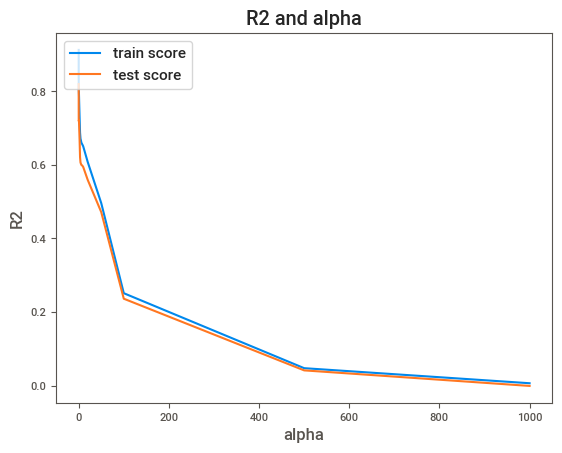

In [54]:
# plotting mean test and train scoes with alpha
l_cv_results['param_alpha'] = l_cv_results['param_alpha'].astype('float32')

# plotting
plt.plot(l_cv_results['param_alpha'], l_cv_results['mean_train_score'])
plt.plot(l_cv_results['param_alpha'], l_cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('R2')

plt.title("R2 and alpha")
plt.legend(['train score', 'test score'], loc='upper left')
plt.show()

In [55]:
# Printing the best hyperparameter alpha
print(l_model_cv.best_params_)

{'alpha': 0.0001}


In [56]:
alpha = 0.0001

lasso = Lasso(alpha=alpha)

lasso.fit(X_train, y_train)

Lasso(alpha=0.0001)

In [57]:
print("Training R2")
print(lasso.score(X_train,y_train))
print("Testing R2")
print(lasso.score(X_test,y_test))

Training R2
0.9114474123544746
Testing R2
0.11616391506962753


In [58]:
params_1 = {'alpha': np.linspace(0.2, 1.5 , num = 50) }

# Applying Lasso
lasso1 = Lasso()

# cross validation
folds = 10
l_model_cv = GridSearchCV(estimator = lasso,
                        param_grid = params_1,
                        scoring= 'r2',
                        cv = folds,
                        return_train_score=True,
                        verbose = 1)

l_model_cv.fit(X_train, y_train)


Fitting 10 folds for each of 50 candidates, totalling 500 fits


GridSearchCV(cv=10, estimator=Lasso(alpha=0.0001),
             param_grid={'alpha': array([0.2       , 0.22653061, 0.25306122, 0.27959184, 0.30612245,
       0.33265306, 0.35918367, 0.38571429, 0.4122449 , 0.43877551,
       0.46530612, 0.49183673, 0.51836735, 0.54489796, 0.57142857,
       0.59795918, 0.6244898 , 0.65102041, 0.67755102, 0.70408163,
       0.73061224, 0.75714286, 0.78367347, 0.81020408, 0.83673469,
       0.86326531, 0.88979592, 0.91632653, 0.94285714, 0.96938776,
       0.99591837, 1.02244898, 1.04897959, 1.0755102 , 1.10204082,
       1.12857143, 1.15510204, 1.18163265, 1.20816327, 1.23469388,
       1.26122449, 1.2877551 , 1.31428571, 1.34081633, 1.36734694,
       1.39387755, 1.42040816, 1.44693878, 1.47346939, 1.5       ])},
             return_train_score=True, scoring='r2', verbose=1)

In [59]:
# Printing the best hyperparameter alpha
print(l_model_cv.best_params_)

{'alpha': 0.3326530612244898}


In [60]:
alpha = 0.3373737373737374

lasso = Lasso(alpha=alpha)

lasso.fit(X_train, y_train)

Lasso(alpha=0.3373737373737374)

In [61]:
print("Training R2")
print(lasso.score(X_train,y_train))
print("Testing R2")
print(lasso.score(X_test,y_test))

Training R2
0.7983719636579596
Testing R2
0.7368147110331345


In [62]:
df_lasso = pd.DataFrame(columns=['Name', 'Value'] )
df_lasso['Name'] = lasso.feature_names_in_  
df_lasso['Value'] = lasso.coef_ 
df_lasso=df_lasso.sort_values(by='Value',ascending=False)
print(df_lasso)

            Name         Value
17     YearBuilt  3.065154e-03
18  YearRemodAdd  2.668123e-03
60    GarageArea  3.203223e-04
44     GrLivArea  2.853397e-04
68   ScreenPorch  2.699255e-04
..           ...           ...
37       Heating -0.000000e+00
38     HeatingQC -0.000000e+00
35     BsmtUnfSF -1.453211e-07
0     MSSubClass -4.577025e-04
69      PoolArea -1.507725e-03

[78 rows x 2 columns]


In [63]:
lasso.coef_

array([-4.57702517e-04, -0.00000000e+00,  1.60585990e-06, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  3.06515411e-03,  2.66812275e-03, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        3.55699864e-05,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        6.76314000e-05, -0.00000000e+00,  1.26210536e-05, -1.45321147e-07,
        1.50244231e-04, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  5.83232540e-05, -0.00000000e+00,
        2.85339690e-04,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -

In [64]:
# Applying Ridge
ridge = Ridge()
# cross validation
folds = 10
r_model_cv = GridSearchCV(estimator = ridge,
                        param_grid = params,
                        scoring= 'r2',
                        cv = folds,
                        return_train_score=True,
                        verbose = 1)
r_model_cv.fit(X_train, y_train)

Fitting 10 folds for each of 28 candidates, totalling 280 fits


GridSearchCV(cv=10, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='r2', verbose=1)

In [65]:
# Printing the best hyperparameter alpha
print(r_model_cv.best_params_)

{'alpha': 0.0001}


In [66]:
r_cv_results = pd.DataFrame(r_model_cv.cv_results_)
r_cv_results = r_cv_results[r_cv_results['param_alpha']<=200]
r_cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.008772,0.005334,0.002692,0.001786,0.0001,{'alpha': 0.0001},0.914317,0.932458,0.887720,0.887897,...,0.912436,0.913015,0.912019,0.928970,0.912179,0.910218,0.910827,0.912039,0.913040,0.005464
1,0.010672,0.003486,0.004387,0.001849,0.001,{'alpha': 0.001},0.914347,0.932455,0.887705,0.887884,...,0.912436,0.913015,0.912019,0.928970,0.912175,0.910218,0.910827,0.912039,0.913040,0.005465
2,0.014860,0.003072,0.004987,0.001262,0.01,{'alpha': 0.01},0.914556,0.932426,0.887543,0.887754,...,0.912430,0.913009,0.912013,0.928963,0.912143,0.910211,0.910821,0.912032,0.913030,0.005465
3,0.012866,0.000299,0.004487,0.000499,0.05,{'alpha': 0.05},0.914015,0.932294,0.886695,0.887186,...,0.912294,0.912881,0.911888,0.928806,0.912126,0.910083,0.910688,0.911890,0.912903,0.005458
4,0.013464,0.002573,0.005286,0.001002,0.1,{'alpha': 0.1},0.911234,0.932121,0.885452,0.886507,...,0.911954,0.912556,0.911568,0.928410,0.912122,0.909757,0.910351,0.911531,0.912586,0.005441


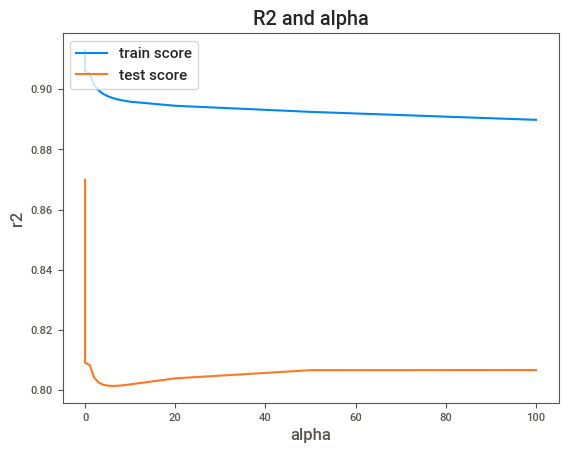

In [67]:
# plotting mean test and train scoes with alpha
r_cv_results['param_alpha'] = r_cv_results['param_alpha'].astype('int32')

# plotting
plt.plot(r_cv_results['param_alpha'], r_cv_results['mean_train_score'])
plt.plot(r_cv_results['param_alpha'], r_cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('r2')
plt.title("R2 and alpha")
plt.legend(['train score', 'test score'], loc='upper left')
plt.show()

In [68]:
print(r_model_cv.best_params_)

{'alpha': 0.0001}


In [69]:
params_1 = {'alpha': np.linspace(0.3,1.5,50)}

In [70]:
# cross validation
folds = 10
r_model_cv = GridSearchCV(estimator = ridge,
                        param_grid = params_1,
                        scoring= 'r2',
                        cv = folds,
                        return_train_score=True,
                        verbose = 1)
r_model_cv.fit(X_train, y_train)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


GridSearchCV(cv=10, estimator=Ridge(),
             param_grid={'alpha': array([0.3       , 0.3244898 , 0.34897959, 0.37346939, 0.39795918,
       0.42244898, 0.44693878, 0.47142857, 0.49591837, 0.52040816,
       0.54489796, 0.56938776, 0.59387755, 0.61836735, 0.64285714,
       0.66734694, 0.69183673, 0.71632653, 0.74081633, 0.76530612,
       0.78979592, 0.81428571, 0.83877551, 0.86326531, 0.8877551 ,
       0.9122449 , 0.93673469, 0.96122449, 0.98571429, 1.01020408,
       1.03469388, 1.05918367, 1.08367347, 1.10816327, 1.13265306,
       1.15714286, 1.18163265, 1.20612245, 1.23061224, 1.25510204,
       1.27959184, 1.30408163, 1.32857143, 1.35306122, 1.37755102,
       1.40204082, 1.42653061, 1.45102041, 1.4755102 , 1.5       ])},
             return_train_score=True, scoring='r2', verbose=1)

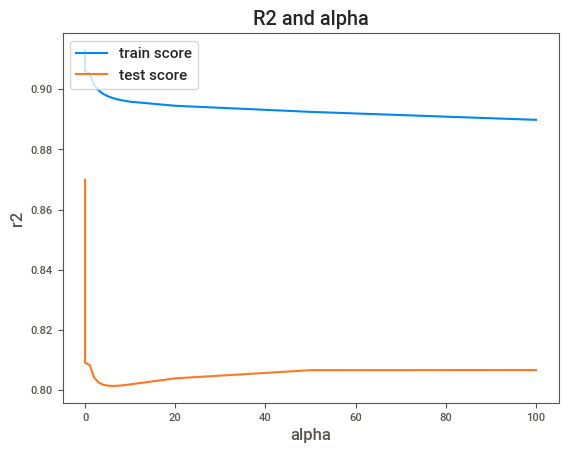

In [71]:
# plotting mean test and train scoes with alpha
r_cv_results['param_alpha'] = r_cv_results['param_alpha'].astype('int32')

# plotting
plt.plot(r_cv_results['param_alpha'], r_cv_results['mean_train_score'])
plt.plot(r_cv_results['param_alpha'], r_cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('r2')
plt.title("R2 and alpha")
plt.legend(['train score', 'test score'], loc='upper left')
plt.show()

In [72]:
print(r_model_cv.best_params_)

{'alpha': 0.3}


In [73]:
#Fitting Ridge model for best alpha and printing coefficients which have been penalised
best_alpha_ridge = r_model_cv.best_params_['alpha']
ridge = Ridge(alpha=best_alpha_ridge, random_state=100)

ridge.fit(X_train, y_train)

print("Ridge Intercept : ", ridge.intercept_)
print("Ridge Coefficient :\n", ridge.coef_)

Ridge Intercept :  20.918342585295438
Ridge Coefficient :
 [-6.76999165e-04 -4.94468526e-02  1.93026603e-06 -1.38668444e-01
 -4.30282010e-02  7.36934525e-03 -7.08868752e-03 -1.31515078e-01
  4.78162534e-03 -4.83415262e-03  7.62661661e-04 -8.89486086e-03
 -4.09939860e-02 -8.02735749e-03  2.79639221e-04  6.49431259e-02
  4.84939535e-02  1.77782127e-03  9.48726301e-04  1.24128872e-02
 -1.99487618e-02 -2.80331701e-03  3.23253999e-03  3.32099210e-03
  3.56395130e-05  7.37708972e-03 -1.60343779e-02  1.66050009e-02
 -1.14664800e-02  5.55973384e-04 -5.74090337e-03  6.67877683e-03
  5.43078101e-05  6.32395376e-03  1.76973085e-05  3.57444821e-06
  7.55793005e-05 -5.70521267e-03 -7.34431419e-03 -3.54400606e-02
  1.68734978e-04  5.34588886e-05  5.68896973e-05  5.71346003e-05
  1.67483089e-04  4.56450909e-02  8.76604166e-03  3.22271083e-02
  1.54316323e-02 -7.87471309e-03 -3.64850966e-02  3.33635414e-04
  1.52094890e-02 -1.24197541e-02  4.06675040e-02  3.94466334e-03
  5.05844045e-03 -3.11766625e-0

In [74]:
# Lets calculate metrics : R2 score and RMSE
y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)

ridge_metric = []
r2_train_lr = r2_score(y_train, y_pred_train)
print("R2 Score (Train) : ", r2_train_lr)
ridge_metric.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print("R2 Score (Test)  : ", r2_test_lr)
ridge_metric.append(r2_test_lr)

rmse_train_lr = mean_squared_error(y_train, y_pred_train) ** 0.5
print("RMSE (Train)     : ", rmse_train_lr)
ridge_metric.append(rmse_train_lr)

rmse_test_lr = mean_squared_error(y_test, y_pred_test) ** 0.5
print("RMSE (Test)      : ", rmse_test_lr)
ridge_metric.append(rmse_test_lr)

R2 Score (Train) :  0.9093731865690038
R2 Score (Test)  :  0.5018742983969406
RMSE (Train)     :  0.12167879454131017
RMSE (Test)      :  0.27381135148988495


In [75]:
print(r_model_cv.best_params_)

{'alpha': 0.3}


In [76]:
# Printing the best hyperparameter alpha
print(l_model_cv.best_params_)

{'alpha': 0.3326530612244898}


In [77]:
lr = Lasso(alpha=0.20404040404040405)
lr.fit(X_train,y_train)
print("Training R2")
print(lr.score(X_train,y_train))
print("Testing R2")
print(lr.score(X_test,y_test))

Training R2
0.8016778251228324
Testing R2
0.7234509066302801


In [78]:
lr = Lasso(alpha=0.6)
lr.fit(X_train,y_train)
print("Training R2")
print(lr.score(X_train,y_train))
print("Testing R2")
print(lr.score(X_test,y_test))

Training R2
0.7894632362114778
Testing R2
0.7539125970815683


In [79]:
lr = Lasso(alpha= 0.3373737373737374)
lr.fit(X_train,y_train)
print("Training R2")
print(lr.score(X_train,y_train))
print("Testing R2")
print(lr.score(X_test,y_test))

Training R2
0.7983719636579596
Testing R2
0.7368147110331345


In [80]:
# Printing the best hyperparameter alpha
print(l_model_cv.best_params_)

{'alpha': 0.3326530612244898}


In [81]:
# Printing the best hyperparameter alpha
print(r_model_cv.best_params_)

{'alpha': 0.3}


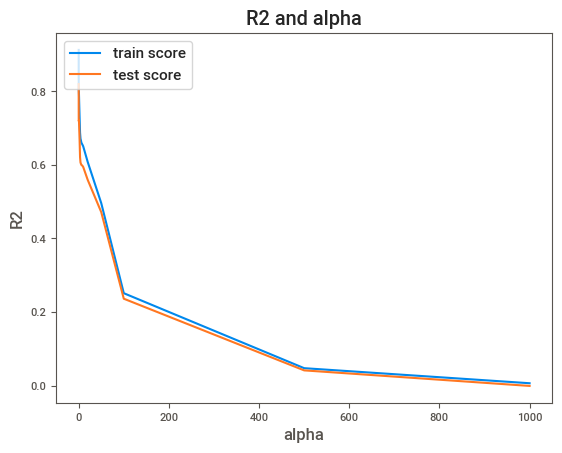

In [82]:
# plotting mean test and train scoes with alpha
l_cv_results['param_alpha'] = l_cv_results['param_alpha'].astype('float32')

# plotting
plt.plot(l_cv_results['param_alpha'], l_cv_results['mean_train_score'])
plt.plot(l_cv_results['param_alpha'], l_cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('R2')

plt.title("R2 and alpha")
plt.legend(['train score', 'test score'], loc='upper left')
plt.show()

In [83]:
# Lets calculate metrics : R2 score and RMSE
y_pred_train = lasso.predict(X_train)
y_pred_test = lasso.predict(X_test)

lasso_metric = []
r2_train_lr = r2_score(y_train, y_pred_train)
print("R2 Score (Train) : ", r2_train_lr)
lasso_metric.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print("R2 Score (Test)  : ", r2_test_lr)
lasso_metric.append(r2_test_lr)

rmse_train_lr = mean_squared_error(y_train, y_pred_train) ** 0.5
print("RMSE (Train)     : ", rmse_train_lr)
lasso_metric.append(rmse_train_lr)

rmse_test_lr = mean_squared_error(y_test, y_pred_test) ** 0.5
print("RMSE (Test)      : ", rmse_test_lr)
lasso_metric.append(rmse_test_lr)

R2 Score (Train) :  0.7983719636579596
R2 Score (Test)  :  0.7368147110331345
RMSE (Train)     :  0.18149388784025947
RMSE (Test)      :  0.1990273583636758


In [84]:
# Creating a table which contain all the metrics

lr_table = {'Metric': ['R2 Score (Train)','R2 Score (Test)', 'RMSE (Train)','RMSE (Test)']}

lr_metric = pd.DataFrame(lr_table ,columns = ['Metric'] )

rg_metric = pd.Series(ridge_metric, name = 'Ridge Regression')
ls_metric = pd.Series(lasso_metric, name = 'Lasso Regression')

final_metric = pd.concat([lr_metric, rg_metric, ls_metric], axis = 1)

final_metric

,Metric,Ridge Regression,Lasso Regression
0,R2 Score (Train),0.909373,0.798372
1,R2 Score (Test),0.501874,0.736815
2,RMSE (Train),0.121679,0.181494
3,RMSE (Test),0.273811,0.199027


Based on the R2 Scores of Train and Test Lasso scores are weighing better and can be given prefrence over ridge.

In [85]:
# Creating a table which contain coefficients of features obtained from Ridge and Lasso models
betas = pd.DataFrame(index=X_train.columns)

betas.rows = X_train.columns

betas['Ridge'] = ridge.coef_
betas['Lasso'] = lasso.coef_

# Peek into the top 20 features just for example
betas.head(20)

,Ridge,Lasso
MSSubClass,-0.000677,-0.000458
MSZoning,-0.049447,-0.000000
LotArea,0.000002,0.000002
Street,-0.138668,-0.000000
Alley,-0.043028,-0.000000
LotShape,0.007369,0.000000
LandContour,-0.007089,-0.000000
Utilities,-0.131515,-0.000000
LotConfig,0.004782,0.000000
LandSlope,-0.004834,-0.000000


In [86]:
# dropping the 5 important variables 
# Drop the top 5 features
X_train_drop = X_train.drop(columns=['YearBuilt', 'YearRemodAdd', 'GarageArea', 'GrLivArea', 'ScreenPorch'], axis=1)
X_test_drop = X_test.drop(columns=['YearBuilt', 'YearRemodAdd', 'GarageArea', 'GrLivArea', 'ScreenPorch'], axis=1)



In [87]:
# Create a Lasso model instance
lasso_drop = Lasso(random_state=100)

# cross validation
lasso_drop_model_cv = GridSearchCV(estimator = lasso_drop, 
                        param_grid = params_1, 
                        scoring= 'r2', 
                        cv = folds,
                        return_train_score=True,
                        verbose = 1)            

lasso_drop_model_cv.fit(X_train_drop, y_train)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


GridSearchCV(cv=10, estimator=Lasso(random_state=100),
             param_grid={'alpha': array([0.3       , 0.3244898 , 0.34897959, 0.37346939, 0.39795918,
       0.42244898, 0.44693878, 0.47142857, 0.49591837, 0.52040816,
       0.54489796, 0.56938776, 0.59387755, 0.61836735, 0.64285714,
       0.66734694, 0.69183673, 0.71632653, 0.74081633, 0.76530612,
       0.78979592, 0.81428571, 0.83877551, 0.86326531, 0.8877551 ,
       0.9122449 , 0.93673469, 0.96122449, 0.98571429, 1.01020408,
       1.03469388, 1.05918367, 1.08367347, 1.10816327, 1.13265306,
       1.15714286, 1.18163265, 1.20612245, 1.23061224, 1.25510204,
       1.27959184, 1.30408163, 1.32857143, 1.35306122, 1.37755102,
       1.40204082, 1.42653061, 1.45102041, 1.4755102 , 1.5       ])},
             return_train_score=True, scoring='r2', verbose=1)

In [88]:
print(lasso_drop_model_cv.best_params_)

{'alpha': 0.5938775510204082}


In [89]:
alpha = 0.5938775510204082

lasso = Lasso(alpha=alpha)

lasso.fit(X_train_drop, y_train)



Lasso(alpha=0.5938775510204082)

In [90]:
print("Training R2")
print(lasso.score(X_train_drop,y_train))
print("Testing R2")
print(lasso.score(X_test_drop,y_test))

Training R2
0.7085549306067964
Testing R2
0.6696542124920101


In [91]:
df_lasso_drop = pd.DataFrame(columns=['Name', 'Value'] )
df_lasso_drop['Name'] = lasso.feature_names_in_
df_lasso_drop['Value'] = lasso.coef_
df_lasso_drop=df_lasso_drop.sort_values(by='Value',ascending=False)
print(df_lasso_drop)

             Name     Value
54    GarageYrBlt  0.003541
40       2ndFlrSF  0.000382
39       1stFlrSF  0.000334
60     WoodDeckSF  0.000244
34    TotalBsmtSF  0.000234
..            ...       ...
32     BsmtFinSF2  0.000000
41   LowQualFinSF -0.000025
62  EnclosedPorch -0.000070
0      MSSubClass -0.000367
64       PoolArea -0.001244

[73 rows x 2 columns]
